In [10]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *


In [145]:
ytopics = []
y = 1990

run_id = 121

[0,1985,1990.1,1995.1,2001.1,2007.1,2013.1,9999]
ars = [
    {"name":"AR0","years":range(0,1985),"n":0},
    {"name":"AR1","years":range(1985,1991),"n":1},
    {"name":"AR2","years":range(1991,1995),"n":2},
    {"name":"AR3","years":range(1995,2001),"n":3},
    {"name":"AR4","years":range(2001,2008),"n":4},
    {"name":"AR5","years":range(2008,2014),"n":5},
    {"name":"AR6","years":range(2014,9999),"n":6}
]
for ar in ars:   
    ytopics = DocTopic.objects.filter(doc__PY__in=ar["years"],run_id=run_id).values('topic_id').annotate(
        ttotal=models.Sum('score')
    ).values('topic_id','topic__title','ttotal')
    ndf =  pd.DataFrame.from_dict(list(ytopics))
    ndf['AP'] = ar["name"]
    ndf['APn'] = ar["n"]
    if ar["name"]=="AR0":
        df = ndf
    else:
        df = df.append(ndf)
    


In [146]:
ndf = df

df['x'] = df.apply(lambda x: x['APn']+(np.random.rand()-0.5)*0.5,axis=1)
df['change'] = df.ttotal - df.groupby(['topic__title']).ttotal.shift(1)
df['pchange'] = (df.ttotal - df.groupby(['topic__title']).ttotal.shift(1)) / df.groupby(['topic__title']).ttotal.shift(1) * 100
df.pchange=df['pchange']
#print(df[['APn','pchange']])
df['pchangen'] = df[['APn','pchange']].groupby('APn').transform(lambda x: x/x.mean())

grouped = df.groupby('APn')

print(grouped.pchange.mean().reset_index())

#for name, group in grouped:
    #print(grouped.pchange.mean())

print(df[df.topic_id==115].head(125))

   APn      pchange
0    1          NaN
1    2  9211.654061
2    3   479.155118
3    4   306.258374
4    5   182.277816
5    6     3.193671
Empty DataFrame
Columns: [AP, APn, topic__title, topic_id, ttotal, x, change, pchange, pchangen]
Index: []


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


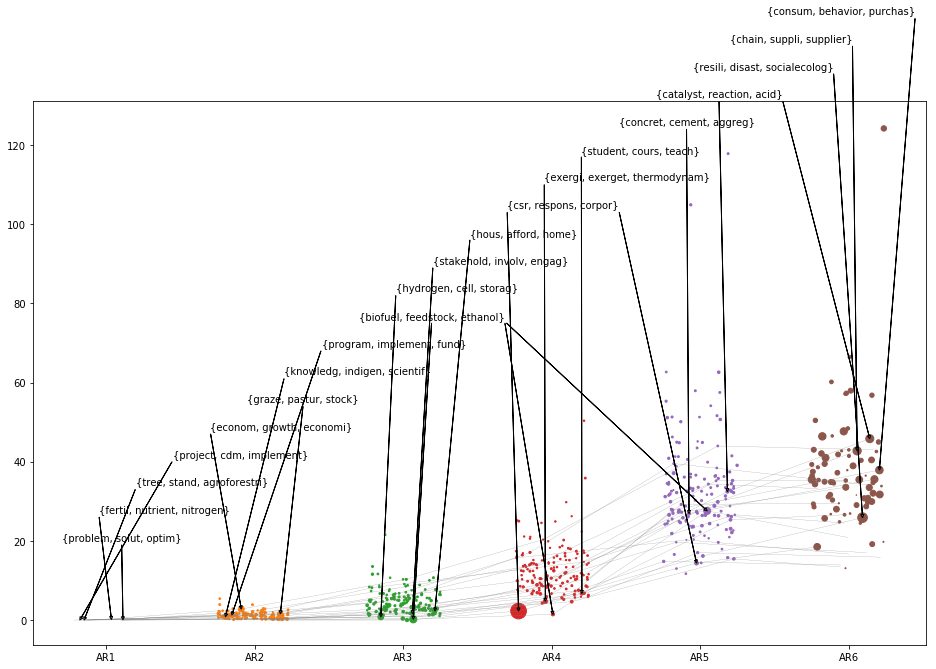

In [147]:
plt.rcParams["figure.figsize"] = [16,10]

topts = []

annotate = True

def f1(x):
    return '{0:.0f}%'.format(x)

ntopics = 4

for ar in ars:
    #break
    topar = df[df.AP==ar["name"]].sort_values(by='pchange', ascending=0).reset_index(drop=True)
    if ar["n"] > 0:
        # Write a table of top topics
        tab = topar[['topic__title','pchange']]
        tab['title'] = tab.apply(lambda x: x['topic__title'].replace('{','').replace('}',''),axis=1)
        tab = tab[['title','pchange']]  
        
        latex = tab.head(5).to_latex(float_format=f1,index=False,column_format='p{1.2cm}r')
        with open("../tables/66_top{}.tex".format(ar["name"]), "w") as f:
            f.write(latex)
 
        # Write a table of bottom topics
        latex = tab.tail(5).to_latex(float_format=f1,index=False,column_format='p{1.2cm}r')
        with open("../tables/66_bottom{}.tex".format(ar["name"]), "w") as f:
            f.write(latex)

        
        #with open("../tables/top{}_tab.tex".format(ar["name"]), "w") as f:
        #    f.write(latex)
        plt.scatter(topar.x,topar.ttotal,s=topar.pchangen*5)
        i = 0
        for index, t in topar.head(ntopics).iterrows():
            
            if t.topic_id in topts:
                i = topts.index(t.topic_id)
                a = 0
            else:
                topts.append(t.topic_id)
                i = topts.index(t.topic_id)
                a = 1
            if annotate:
                text = plt.annotate(
                    t.topic__title,
                    #t.topic__title.replace(',','\n') + " (+{}%)".format(round(t.pchange*100)),
                    xy=(t.x,t.ttotal),
                    xytext=(0.7+i*0.25,20+i*7),
                    arrowprops=dict(facecolor='grey',width=0.01,headwidth=3,headlength=3,shrink=0.0001),
                    color = None
                    #size=0.5
                )
                text.set_alpha(a)
            else:
                plt.text(
                    t.x,
                    t.ttotal,
                    str(t.topic_id) #+ " (+{}%)".format(round(t.pchange*100))                
                )
        #for index, t in topar.tail().iterrows():
        #    plt.text(t.x,t.ttotal,t.topic__title)
        
tops = df[df.topic_id.isin(topts)]
tops = tops[tops.APn>0]

for name, group in tops.groupby(['topic_id']):
    plt.plot(group.x,group.ttotal,c="grey",lw=0.2)
    
plt.xticks([1,2,3,4,5,6],["AR1","AR2","AR3","AR4","AR5","AR6"])

wide = tops.pivot(index='topic__title',columns='AP',values='pchange').reset_index()
wide.columns.name = ''
wide= wide.reset_index(drop=True)

wider = tops[['topic_id','topic__title']].drop_duplicates().merge(wide,how="left").sort_values(by='topic_id')

i = 0
if not annotate:
    for index, t in wider.iterrows():
        i+=1
        plt.text(0.7,250-i*10,"{} : {}".format(t.topic_id,t.topic__title))
        
plt.savefig('../plots/hot_topics.png',bbox_inches='tight')             
plt.show()



In [61]:
ndf.tail()



ndf['ntotal'] = 1

ndf = ndf.reset_index(drop=True)

print(ndf.head())

for name, group in ndf.groupby('topic__title'):
    i = 0
    for index, row in group.iterrows():
        if i==0:
            ndf['ntotal'][index] = 1
        else:
            ndf['ntotal'][index] = l * (1+ndf['pchange'][index]/100)
        l = ndf['ntotal'][index] 
        i+=1

ndf.tail()

    AP  APn              topic__title  topic_id    ttotal         x  change  \
0  AR1    1  {sustain, concept, issu}   11048.0  0.114977  0.956889     NaN   
1  AR1    1      {soil, eros, fertil}   11049.0  0.059913  1.088616     NaN   
2  AR1    1    {energi, renew, sourc}   11050.0  0.013373  0.907748     NaN   
3  AR1    1  {water, suppli, qualiti}   11051.0  0.012125  1.042716     NaN   
4  AR1    1  {forest, forestri, tree}   11052.0  0.057099  1.091711     NaN   

   pchange  pchangen  ntotal  
0      NaN       NaN       1  
1      NaN       NaN       1  
2      NaN       NaN       1  
3      NaN       NaN       1  
4      NaN       NaN       1  


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,AP,APn,topic__title,topic_id,ttotal,x,change,pchange,pchangen,ntotal
579,AR6,6,"{resili, adapt, vulner}",11143.0,31.093710,5.935299,9.605625,44.702098,10.956798,29784
580,AR6,6,"{recycl, aggreg, metal}",11144.0,21.554483,5.850400,2.441084,12.771584,3.130405,64
581,AR6,6,"{exergi, effici, exerget}",11145.0,31.745663,6.001854,3.981200,14.339193,3.514637,61
582,AR6,6,"{biofuel, fuel, ethanol}",11146.0,27.770299,6.066725,-6.889688,-19.877931,-4.872220,126
583,AR6,6,"{develop, sustain, strategi}",11147.0,57.724381,6.036721,-7.102250,-10.955760,-2.685334,935


In [62]:
ndf[ndf.topic_id==11048.0]

,AP,APn,topic__title,topic_id,ttotal,x,change,pchange,pchangen,ntotal
0,AR1,1,"{sustain, concept, issu}",11048.0,0.114977,0.956889,NaN,NaN,NaN,1
173,AR2,2,"{sustain, concept, issu}",11048.0,5.995936,2.248883,5.880958,5114.886470,0.562507,52
184,AR3,3,"{sustain, concept, issu}",11048.0,23.165462,2.846795,17.169527,286.352757,0.652075,200
284,AR4,4,"{sustain, concept, issu}",11048.0,51.440264,3.893209,28.274801,122.055847,0.579855,444
384,AR5,5,"{sustain, concept, issu}",11048.0,119.124610,5.247793,67.684346,131.578537,0.717116,1028
484,AR6,6,"{sustain, concept, issu}",11048.0,108.418818,5.877497,-10.705792,-8.987053,-2.202790,935


In [148]:
ytopics = []
y = 1990

run_id = 112

[0,1985,1990.1,1995.1,2001.1,2007.1,2013.1,9999]
ars = [
    {"name":"AR0","years":range(0,1985),"n":0},
    {"name":"AR1","years":range(1985,1991),"n":1},
    {"name":"AR2","years":range(1991,1995),"n":2},
    {"name":"AR3","years":range(1995,2001),"n":3},
    {"name":"AR4","years":range(2001,2008),"n":4},
    {"name":"AR5","years":range(2008,2014),"n":5},
    {"name":"AR6","years":range(2014,9999),"n":6}
]
for ar in ars:   
    ytopics = DocTopic.objects.filter(doc__PY__in=ar["years"],run_id=run_id).values('topic_id').annotate(
        ttotal=models.Sum('score')
    ).values('topic_id','topic__title','ttotal')
    ndf =  pd.DataFrame.from_dict(list(ytopics))
    ndf['AP'] = ar["name"]
    ndf['APn'] = ar["n"]
    if ar["name"]=="AR0":
        df = ndf
    else:
        df = df.append(ndf)
        
        
        
df.head()

,AP,APn,topic__title,topic_id,ttotal
0,AR1,1,"{sustain, concept, issu}",11048.0,0.114977
1,AR1,1,"{soil, eros, fertil}",11049.0,0.059913
2,AR1,1,"{energi, renew, sourc}",11050.0,0.013373
3,AR1,1,"{water, suppli, qualiti}",11051.0,0.012125
4,AR1,1,"{forest, forestri, tree}",11052.0,0.057099


In [206]:
ytotals = df.groupby(['APn'], as_index=False).ttotal.sum().rename(columns = {'ttotal':'ytotal'})
df = pd.merge(df,ytotals)
df['yprop'] = df.ttotal / df.ytotal
df['pchange'] = (df.yprop - df.groupby(['topic__title']).yprop.shift(1)) / df.groupby(['topic__title']).yprop.shift(1) * 100
df['x'] = df.apply(lambda x: x['APn']+(np.random.rand()-0.5)*0.5,axis=1)
df.tail()

,AP,APn,topic__title,topic_id,ttotal,ytotal,yprop,pchange,x,ntotal
579,AR6,6,"{resili, adapt, vulner}",11143.0,31.093710,3879.938395,0.008014,39.475756,6.184970,1888.413059
580,AR6,6,"{recycl, aggreg, metal}",11144.0,21.554483,3879.938395,0.005555,8.698507,6.134620,221.503513
581,AR6,6,"{exergi, effici, exerget}",11145.0,31.745663,3879.938395,0.008182,10.209496,5.831804,214.523780
582,AR6,6,"{biofuel, fuel, ethanol}",11146.0,27.770299,3879.938395,0.007157,-22.771775,5.931852,450.218520
583,AR6,6,"{develop, sustain, strategi}",11147.0,57.724381,3879.938395,0.014878,-14.171855,6.050688,60.401793


In [150]:
df['ntotal'] = 1.00
for name, group in df.groupby('topic__title'):
    i = 0
    for index, row in group.iterrows():
        if i==0:
            l = 100.0
        else:
            l = l * (1+df['pchange'][index]/100)
        df['ntotal'][index] = l
        i+=1

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


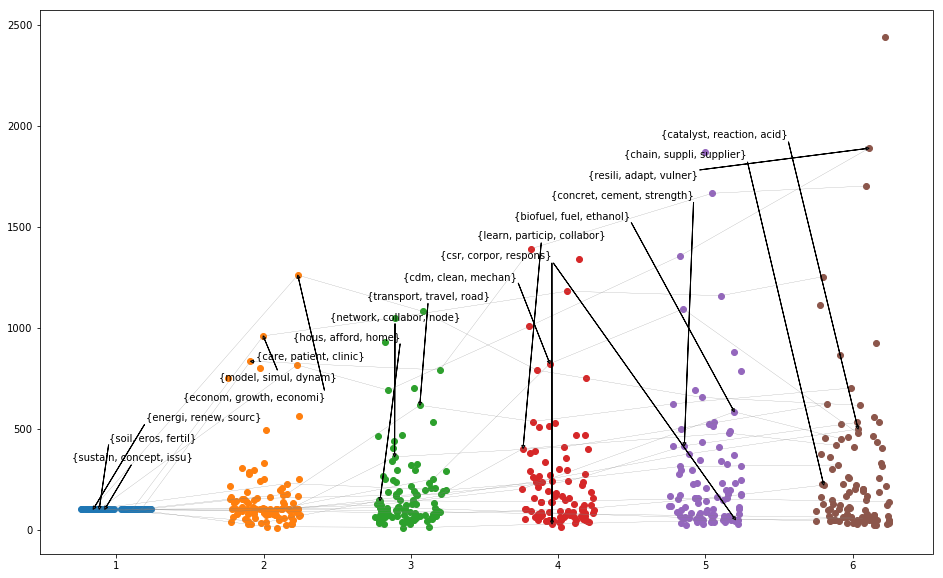

In [144]:


ntopics = 3

topts = []

for ar in ars:
    #break
    topar = df[df.AP==ar["name"]].sort_values(by='pchange', ascending=0).reset_index(drop=True)
    if ar["n"] > 0:
        plt.scatter(topar.x,topar.ntotal)
        #continue
        i = 0
        for index, t in topar.head(ntopics).iterrows():           
            if t.topic_id in topts:
                i = topts.index(t.topic_id)
                a = 0
            else:
                topts.append(t.topic_id)
                i = topts.index(t.topic_id)
                a = 1
                
            text = plt.annotate(
                t.topic__title,
                #t.topic__title.replace(',','\n') + " (+{}%)".format(round(t.pchange*100)),
                xy=(t.x,t.ntotal),
                xytext=(0.7+i*0.25,340+i*100),
                arrowprops=dict(facecolor='grey',width=0.01,headwidth=3,headlength=3,shrink=0.0001),
                color = None
                #size=0.5
            )
            text.set_alpha(a)

tops = df[df.topic_id.isin(topts)]
tops = tops[tops.APn>0]
                
for name, group in tops.groupby(['topic_id']):
    plt.plot(group.x,group.ntotal,c="grey",lw=0.2)
                
                
plt.show()

In [219]:
print(topts)
df

[11866.0, 11835.0, 11813.0, 11788.0, 11869.0, 11885.0, 11849.0, 11897.0, 11792.0, 11879.0, 11890.0, 11882.0, 11804.0, 11843.0, 11808.0, 11861.0, 11846.0, 11812.0, 11771.0, 11871.0]


,AP,APn,topic__title,topic_id,ttotal,ytotal,yprop,pchange,x,ntotal
0,AR1,1,"{sustain, concept, issu}",11048.0,0.114977,2.458899,0.046760,NaN,0.789724,100.000000
1,AR1,1,"{soil, eros, fertil}",11049.0,0.059913,2.458899,0.024366,NaN,1.083577,100.000000
2,AR1,1,"{energi, renew, sourc}",11050.0,0.013373,2.458899,0.005439,NaN,1.020098,100.000000
3,AR1,1,"{water, suppli, qualiti}",11051.0,0.012125,2.458899,0.004931,NaN,0.819056,100.000000
4,AR1,1,"{forest, forestri, tree}",11052.0,0.057099,2.458899,0.023221,NaN,1.116426,100.000000
5,AR1,1,"{health, diseas, mental}",11053.0,0.061221,2.458899,0.024898,NaN,0.978935,100.000000
6,AR1,1,"{urban, area, space}",11054.0,0.046508,2.458899,0.018914,NaN,0.765766,100.000000
7,AR1,1,"{plan, strateg, spatial}",11055.0,0.046460,2.458899,0.018895,NaN,1.072861,100.000000
8,AR1,1,"{environment, impact, environ}",11056.0,0.047315,2.458899,0.019242,NaN,0.756199,100.000000
9,AR1,1,"{manag, integr, strategi}",11057.0,0.072416,2.458899,0.029451,NaN,0.753723,100.000000


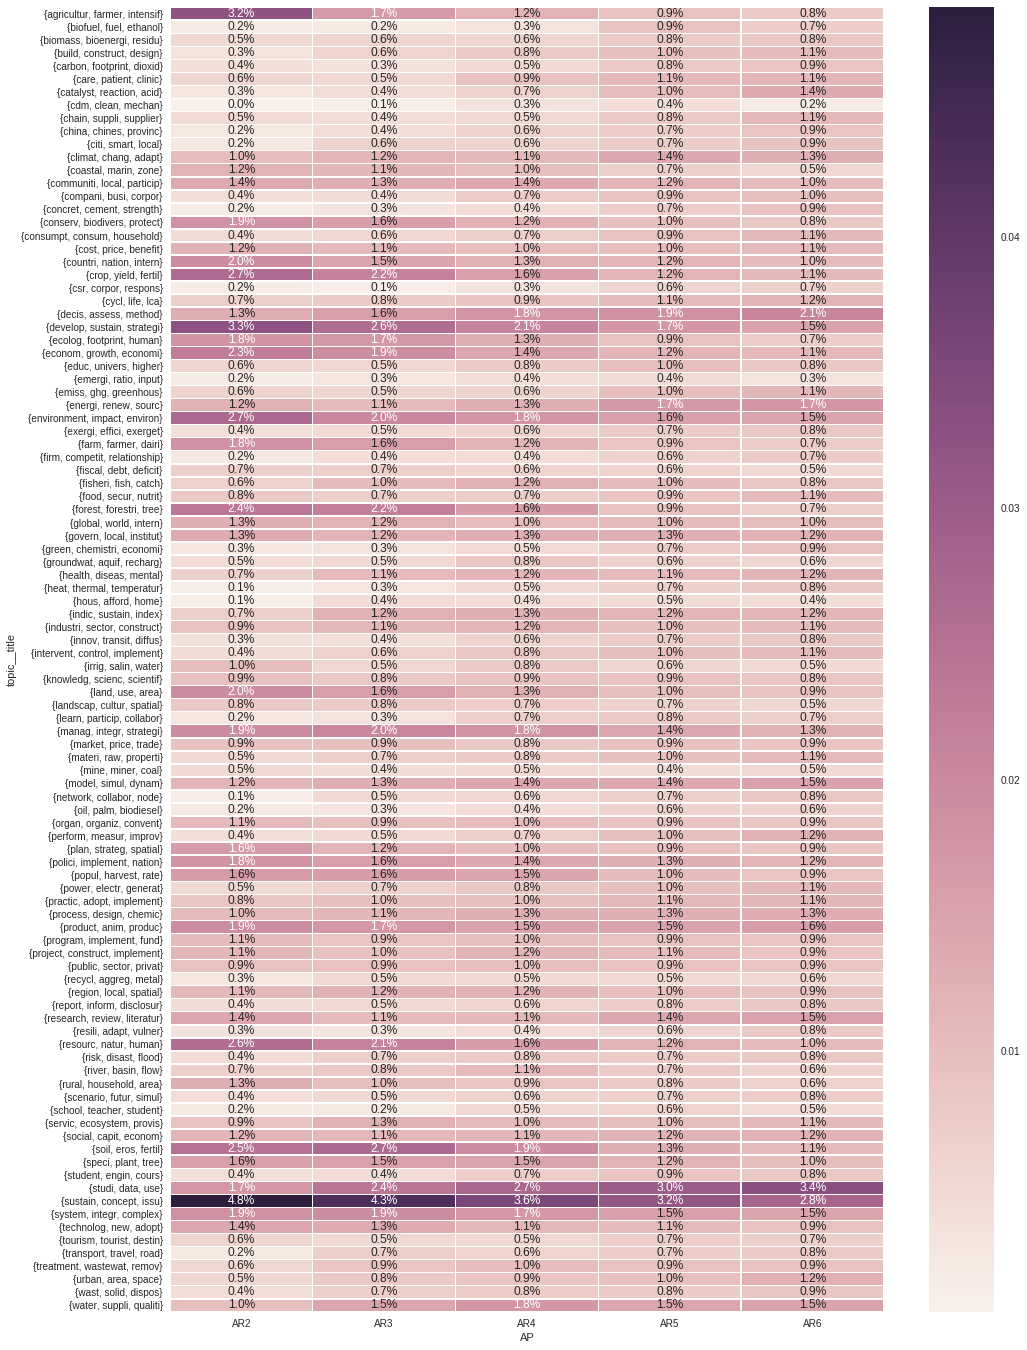

In [271]:
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = [16,24]

df['pchangen'] = df[['APn','pchange']].groupby('APn').transform(lambda x: x/x.mean())

ppdf = df[df['APn'] > 1].pivot('topic__title','AP','yprop').fillna(0)


sns.heatmap(ppdf, annot=True, fmt=".1%", linewidths=.5)

plt.show()

In [278]:
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = [16,24]

df = df[df['APn']>1]

print(df)

yav = df.groupby(['APn'], as_index=False).pchange.mean().rename(columns = {'ttotal':'yav'})
print(yav)
df = pd.merge(df,yav)

df['pchangen'] = df['pchange'] / df['yav']

ppdf = df[df['APn'] > 1].pivot('topic__title','AP','pchangen').fillna(0)


sns.heatmap(ppdf, annot=True, fmt=".1%", linewidths=.5)

plt.show()

Empty DataFrame
Columns: [AP, topic__title, topic_id, ttotal, ytotal, yprop, x, ntotal, pchangen, APn, pchange]
Index: []
Empty DataFrame
Columns: [APn, pchange]
Index: []


/usr/local/lib/python3.4/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


KeyError: 'yav'